## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# # (re-)load layers
# %run modules.ipynb
import torch
import numpy as np
import unittest
from modules import (
    Module, Sequential, Linear, SoftMax, LogSoftMax, BatchNormalization, ChannelwiseScaling,
    Dropout, ReLU, LeakyReLU, ELU, SoftPlus, ClassNLLCriterion, ClassNLLCriterionUnstable,
    Conv2d, MaxPool2d, Flatten, Criterion, sgd_momentum, adam_optimizer
)

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

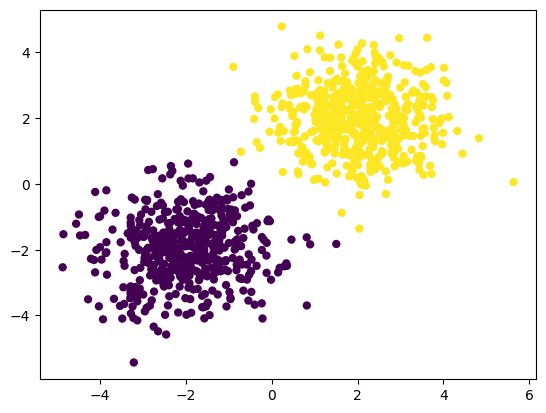

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [6]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

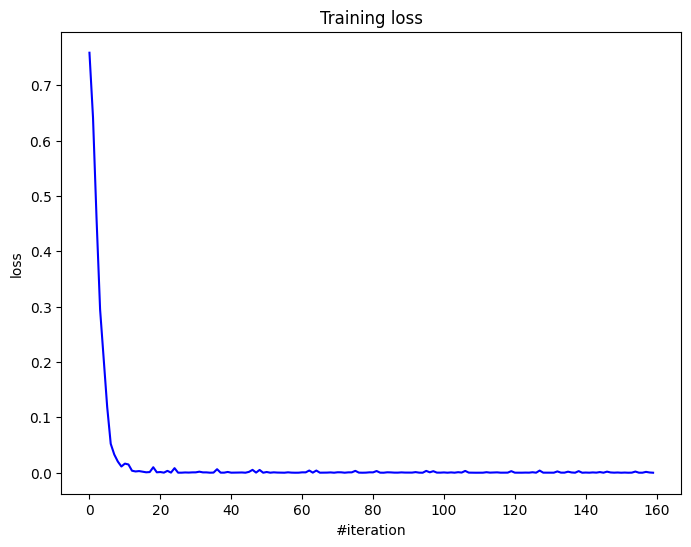

Current loss: 0.000020


In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [10]:
import gzip
import os
import numpy as np

def load_mnist_images(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28)
    return (data / np.float32(256)).squeeze()

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data


X_train = load_mnist_images(r'C:\Users\ekart\YS_last_hw\mnist\train-images-idx3-ubyte.gz')
y_train = load_mnist_labels(r'C:\Users\ekart\YS_last_hw\mnist\train-labels-idx1-ubyte.gz')
X_test = load_mnist_images(r'C:\Users\ekart\YS_last_hw\mnist\t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels(r'C:\Users\ekart\YS_last_hw\mnist\t10k-labels-idx1-ubyte.gz')


X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

flatten = True  
if flatten:
    X_train = X_train.reshape([-1, 28**2])
    X_val = X_val.reshape([-1, 28**2])
    X_test = X_test.reshape([-1, 28**2])


One-hot encode the labels first.

In [11]:
def one_hot(labels):
    return np.eye(10)[labels.reshape(-1)]

one_hot_y_train = one_hot(y_train)
one_hot_y_val = one_hot(y_val)
one_hot_y_test = one_hot(y_test)

X_train = X_train.reshape([len(X_train),-1])
X_val = X_val.reshape([len(X_val),-1])
X_test = X_test.reshape([len(X_test),-1])

def accuracy(prediction, label):
    pred = np.argmax(prediction, axis = -1)
    return 1 - len(np.nonzero(label-pred)[0])/len(label)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

n_epoch = 30 out of 30
Current duration of training 
 for ReLU: 86.6502 s, 
 for ELU: 93.8852 s, 
 for LeakyReLU: 90.5737 s, 
 for SoftPlus: 90.8222 s


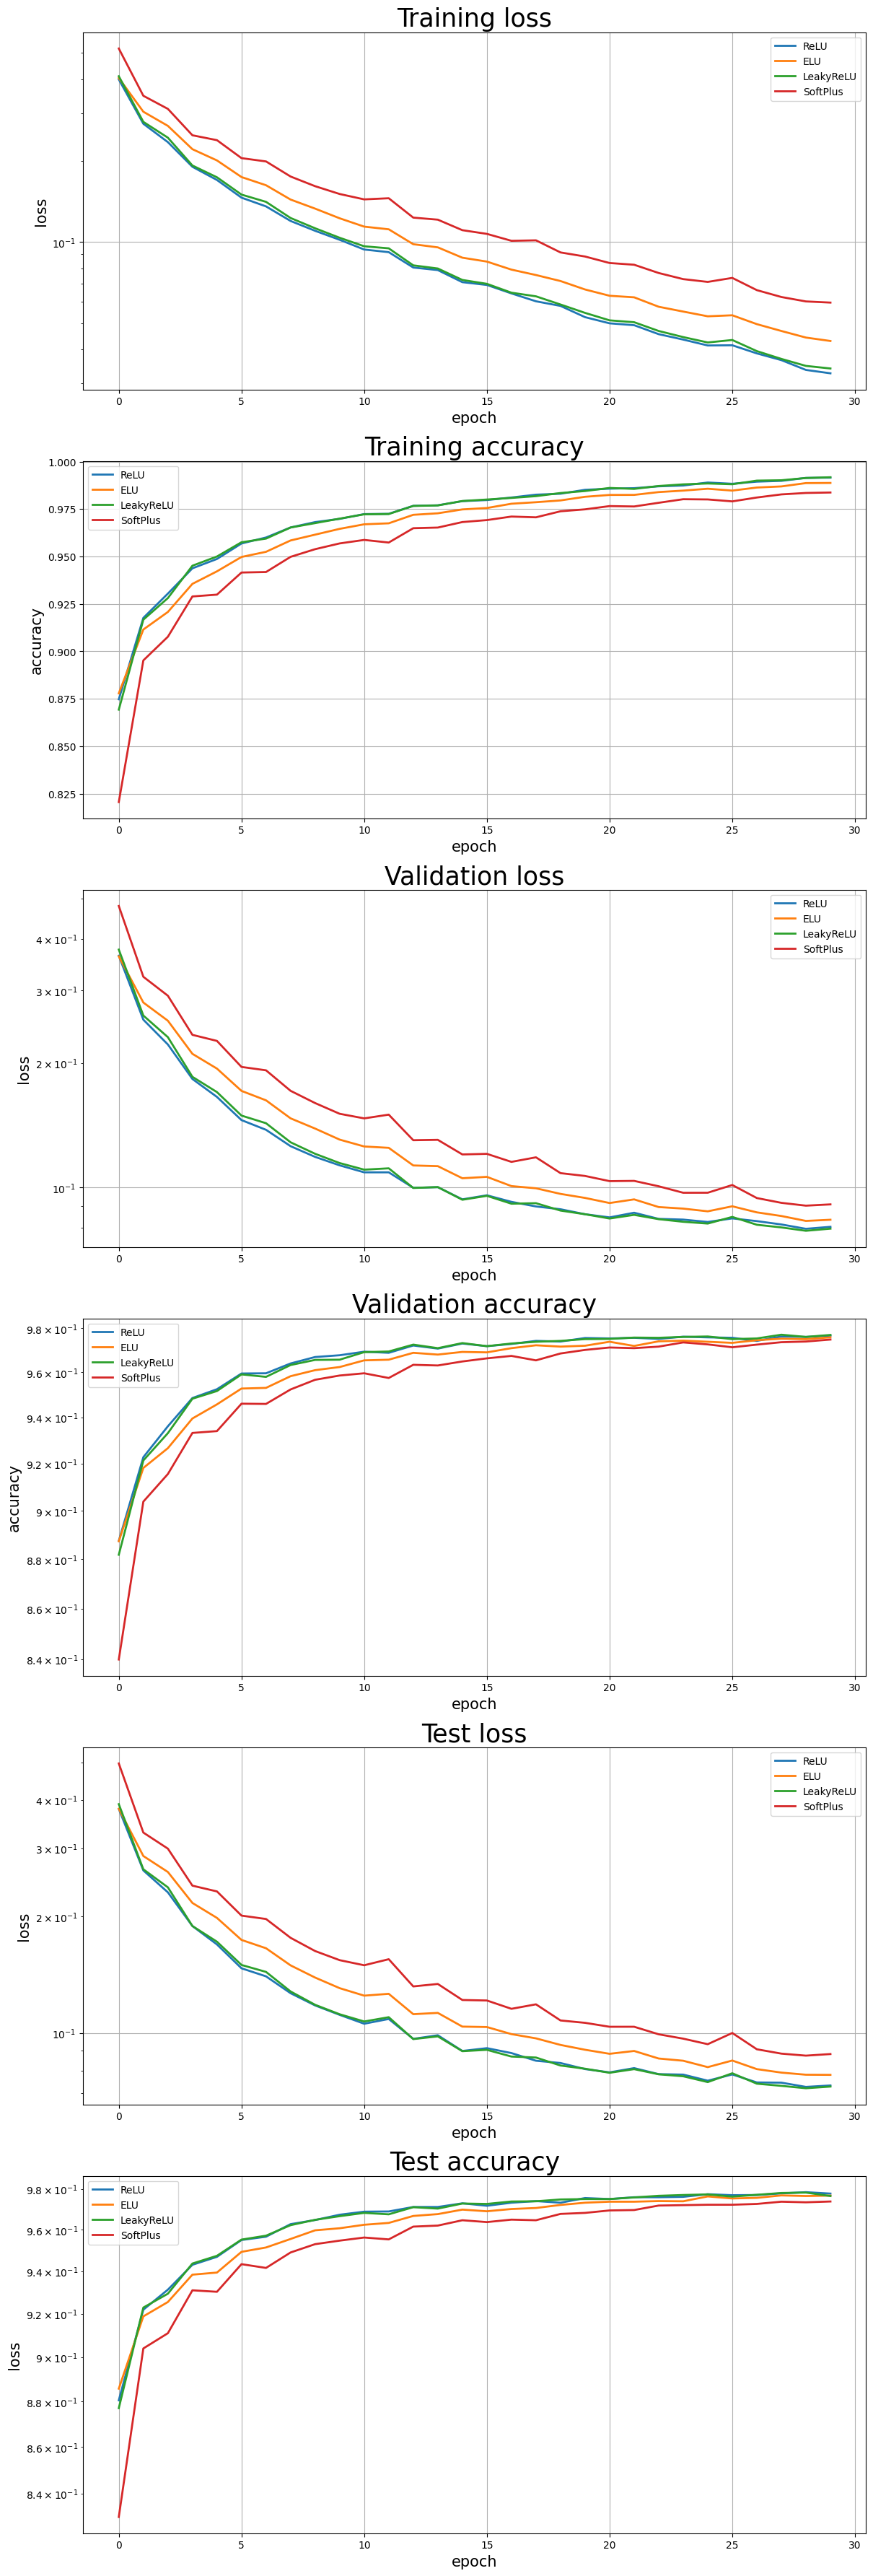

Resulting duration of training: 
 for ReLU: 86.6502 s, 
 for ELU: 93.8852 s, 
 for LeakyReLU: 90.5737 s, 
 for SoftPlus: 90.8222 s


In [12]:
net_relu = Sequential()
net_relu.add(Linear(28*28, 200))
net_relu.add(ReLU())
net_relu.add(Linear(200,10))
net_relu.add(LogSoftMax())
criterion_relu = ClassNLLCriterion()

net_elu = Sequential()
net_elu.add(Linear(28*28, 200))
net_elu.add(ELU())
net_elu.add(Linear(200,10))
net_elu.add(LogSoftMax())
criterion_elu = ClassNLLCriterion()

net_leakrelu = Sequential()
net_leakrelu.add(Linear(28*28, 200))
net_leakrelu.add(LeakyReLU())
net_leakrelu.add(Linear(200,10))
net_leakrelu.add(LogSoftMax())
criterion_leakrelu = ClassNLLCriterion()

net_soft = Sequential()
net_soft.add(Linear(28*28, 200))
net_soft.add(SoftPlus())
net_soft.add(Linear(200,10))
net_soft.add(LogSoftMax())
criterion_soft = ClassNLLCriterion()


n_epoch = 30
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

time_relu = 0
time_elu = 0
time_leakrelu = 0
time_soft = 0

val_acc_relu = []
val_loss_relu = []
train_acc_relu = []
train_loss_relu = []
test_loss_relu = []
test_acc_relu = []

val_acc_elu = []
val_loss_elu = []
train_acc_elu = []
train_loss_elu = []
test_loss_elu = []
test_acc_elu = []

val_acc_leakrelu = []
val_loss_leakrelu = []
train_acc_leakrelu = []
train_loss_leakrelu = []
test_loss_leakrelu = []
test_acc_leakrelu = []

val_acc_soft = []
val_loss_soft = []
train_acc_soft = []
train_loss_soft = []
test_loss_soft = []
test_acc_soft = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        
        net_relu.zeroGradParameters()
        net_elu.zeroGradParameters()
        net_leakrelu.zeroGradParameters()
        net_soft.zeroGradParameters()
        
        time_relu_start = time()
        predictions_relu = net_relu.forward(x_batch)
        loss_relu = criterion_relu.forward(predictions_relu, y_batch)
        dp_relu = criterion_relu.backward(predictions_relu, y_batch)
        net_relu.backward(x_batch, dp_relu)
        sgd_momentum(net_relu.getParameters(), 
                     net_relu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_relu += time() - time_relu_start 
        
        time_elu_start = time()
        predictions_elu = net_elu.forward(x_batch)
        loss_elu = criterion_elu.forward(predictions_elu, y_batch)
        dp_elu = criterion_elu.backward(predictions_elu, y_batch)
        net_elu.backward(x_batch, dp_elu)
        sgd_momentum(net_elu.getParameters(), 
                     net_elu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_elu += time() - time_elu_start
        
        time_leakrelu_start = time()
        predictions_leakrelu = net_leakrelu.forward(x_batch)
        loss_leakrelu = criterion_leakrelu.forward(predictions_leakrelu, y_batch)
        dp_leakrelu = criterion_leakrelu.backward(predictions_leakrelu, y_batch)
        net_leakrelu.backward(x_batch, dp_leakrelu)
        sgd_momentum(net_leakrelu.getParameters(), 
                     net_leakrelu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_leakrelu +=  time() - time_leakrelu_start
        
        time_soft_start = time()
        predictions_soft = net_soft.forward(x_batch)
        loss_soft = criterion_soft.forward(predictions_soft, y_batch)
        dp_soft = criterion_soft.backward(predictions_soft, y_batch)
        net_soft.backward(x_batch, dp_soft)
        sgd_momentum(net_soft.getParameters(), 
                     net_soft.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        time_soft += time() - time_soft_start
        

    pred_train_relu = net_relu.forward(X_train)
    train_loss_relu.append(criterion_relu.forward(pred_train_relu, one_hot_y_train))
    train_acc_relu.append(accuracy(pred_train_relu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_relu = net_relu.forward(X_val)
    val_loss_relu.append(criterion_relu.forward(pred_val_relu, one_hot_y_val))
    val_acc_relu.append(accuracy(pred_val_relu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_relu = net_relu.forward(X_test)
    test_loss_relu.append(criterion_relu.forward(pred_test_relu, one_hot_y_test))
    test_acc_relu.append(accuracy(pred_test_relu,np.argmax(one_hot_y_test,axis = -1)))
    
    
    pred_train_elu = net_elu.forward(X_train)
    train_loss_elu.append(criterion_elu.forward(pred_train_elu, one_hot_y_train))
    train_acc_elu.append(accuracy(pred_train_elu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_elu = net_elu.forward(X_val)
    val_loss_elu.append(criterion_elu.forward(pred_val_elu, one_hot_y_val))
    val_acc_elu.append(accuracy(pred_val_elu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_elu = net_elu.forward(X_test)
    test_loss_elu.append(criterion_elu.forward(pred_test_elu, one_hot_y_test))
    test_acc_elu.append(accuracy(pred_test_elu,np.argmax(one_hot_y_test,axis = -1)))
    
    
    pred_train_leakrelu = net_leakrelu.forward(X_train)
    train_loss_leakrelu.append(criterion_leakrelu.forward(pred_train_leakrelu, one_hot_y_train))
    train_acc_leakrelu.append(accuracy(pred_train_leakrelu,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_leakrelu = net_leakrelu.forward(X_val)
    val_loss_leakrelu.append(criterion_leakrelu.forward(pred_val_leakrelu, one_hot_y_val))
    val_acc_leakrelu.append(accuracy(pred_val_leakrelu,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_leakrelu = net_leakrelu.forward(X_test)
    test_loss_leakrelu.append(criterion_leakrelu.forward(pred_test_leakrelu, one_hot_y_test))
    test_acc_leakrelu.append(accuracy(pred_test_leakrelu,np.argmax(one_hot_y_test,axis = -1)))
    
    
    pred_train_soft = net_soft.forward(X_train)
    train_loss_soft.append(criterion_soft.forward(pred_train_soft, one_hot_y_train))
    train_acc_soft.append(accuracy(pred_train_soft,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_soft = net_soft.forward(X_val)
    val_loss_soft.append(criterion_soft.forward(pred_val_soft, one_hot_y_val))
    val_acc_soft.append(accuracy(pred_val_soft,np.argmax(one_hot_y_val,axis = -1)))
    pred_test_soft = net_soft.forward(X_test)
    test_loss_soft.append(criterion_soft.forward(pred_test_soft, one_hot_y_test))
    test_acc_soft.append(accuracy(pred_test_soft,np.argmax(one_hot_y_test,axis = -1)))
    
    
        

    # Visualize
    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch)) 
    print('Current duration of training \n for ReLU: {} s, \n for ELU: {} s, \n for LeakyReLU: {} s, \n for SoftPlus: {} s'.format(round(time_relu,4), round(time_elu,4), round(time_leakrelu,4), round(time_soft,4)))
    plt.figure(figsize=(14, 45))

    plt.subplot(6,1,1)
    plt.title("Training loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(train_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(train_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(train_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()


    plt.subplot(6,1,2)
    plt.title("Training accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("accuracy", fontsize = 15)
    plt.plot(train_acc_relu, lw = 2, label = 'ReLU')
    plt.plot(train_acc_elu, lw = 2, label = 'ELU')
    plt.plot(train_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.plot(train_acc_soft, lw = 2, label = 'SoftPlus')    
    plt.grid(True)
    plt.legend()
    
    plt.subplot(6,1,3)
    plt.title("Validation loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(val_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(val_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(val_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(6,1,4)
    plt.title("Validation accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("accuracy", fontsize = 15)
    plt.semilogy(val_acc_relu, lw = 2, label = 'ReLU')
    plt.semilogy(val_acc_elu, lw = 2, label = 'ELU')
    plt.semilogy(val_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(val_acc_soft, lw = 2, label = 'SoftPlus') 
    plt.grid(True)
    plt.legend()
    
    
    plt.subplot(6,1,5)
    plt.title("Test loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_loss_relu, lw = 2, label = 'ReLU')
    plt.semilogy(test_loss_elu, lw = 2, label = 'ELU')
    plt.semilogy(test_loss_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(test_loss_soft, lw = 2, label = 'SoftPlus')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(6,1,6)
    plt.title("Test accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_acc_relu, lw = 2, label = 'ReLU')
    plt.semilogy(test_acc_elu, lw = 2, label = 'ELU')
    plt.semilogy(test_acc_leakrelu, lw = 2, label = 'LeakyReLU')
    plt.semilogy(test_acc_soft, lw = 2, label = 'SoftPlus') 
    plt.grid(True)
    plt.legend()
    
    plt.show()
    print('Resulting duration of training: \n for ReLU: {} s, \n for ELU: {} s, \n for LeakyReLU: {} s, \n for SoftPlus: {} s'.format(round(time_relu,4), round(time_elu,4), round(time_leakrelu,4), round(time_soft,4)))

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

n_epoch = 30 out of 30
Current duration of training: 
 for ReLU without normalization: 85.405 s, 
 for ReLU with normalization: 88.2291 s


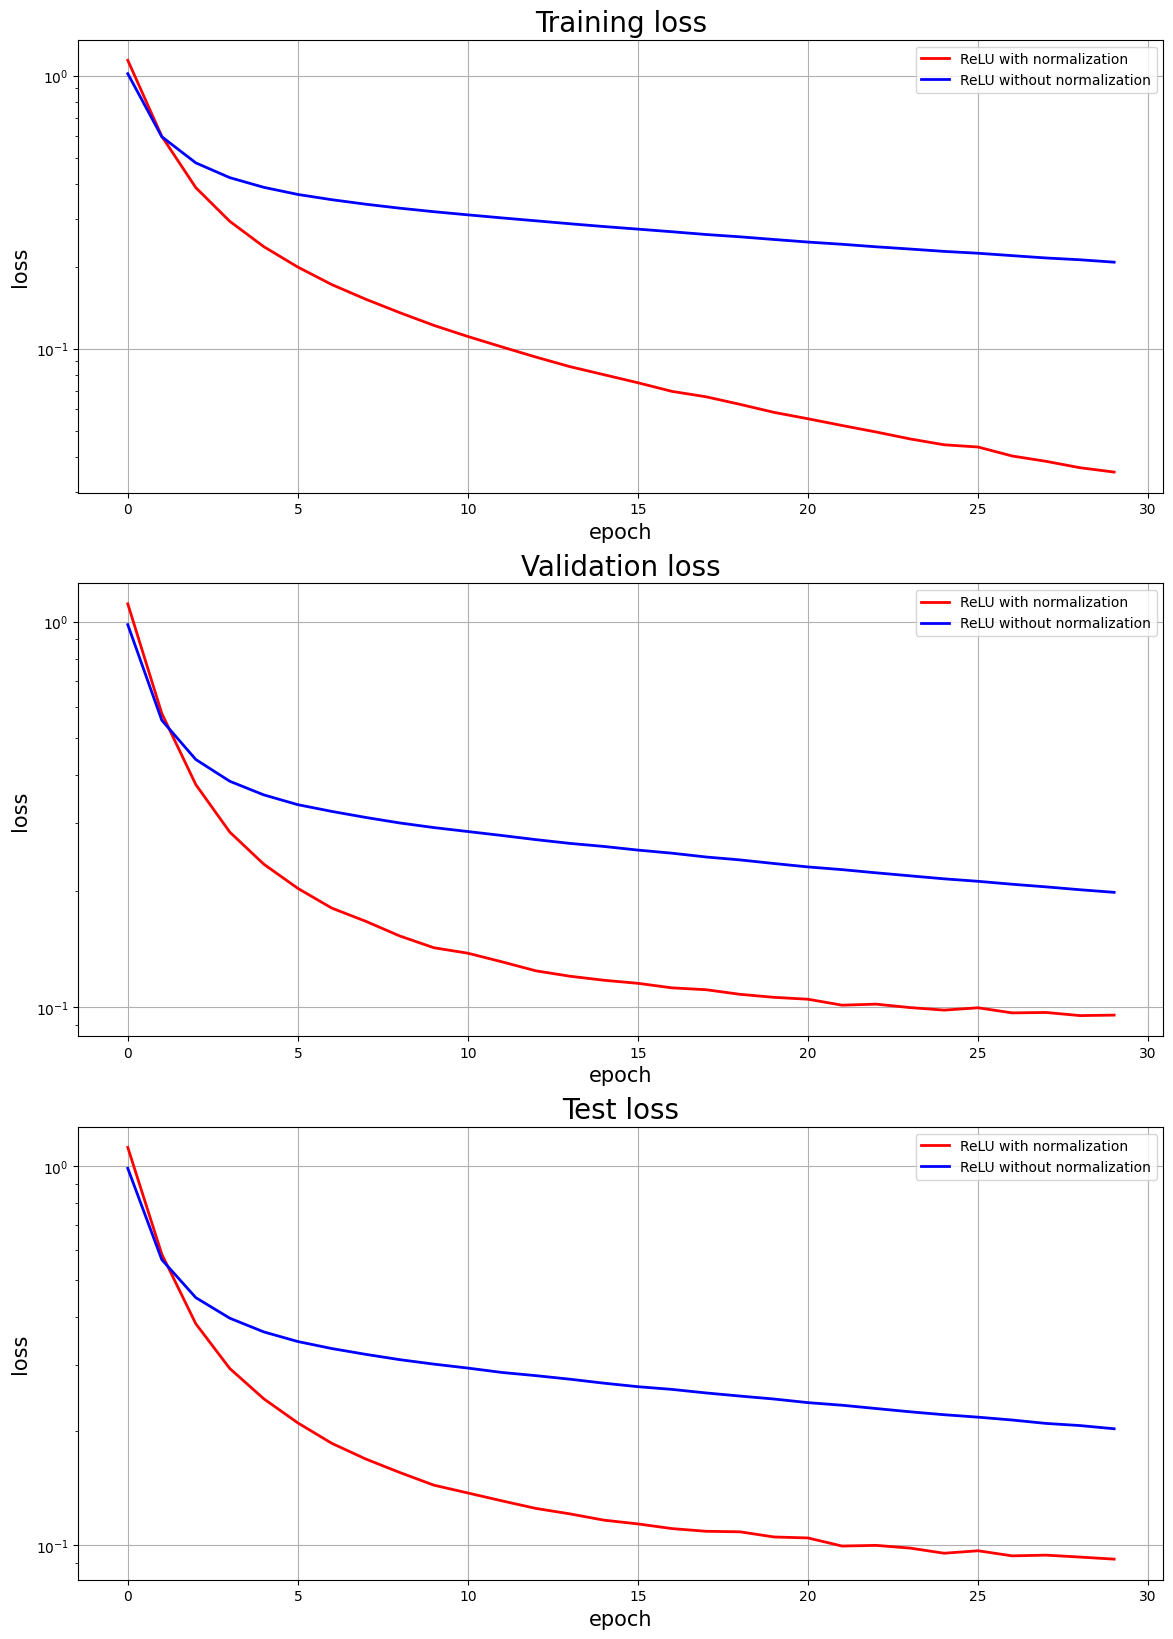

Resulting duration of training: 
 for ReLU without normalization: 85.405 s, 
 for ReLU with normalization: 88.2291 s


In [13]:
n_epoch = 30
batch_size = 1000


net_r = Sequential()
net_r.add(Linear(28*28, 100))
net_r.add(ReLU())
net_r.add(Linear(100,10))
net_r.add(LogSoftMax())
criterion_r = ClassNLLCriterion()

net_norm = Sequential()
net_norm.add(Linear(28*28, 100))
net_norm.add(BatchNormalization())
net_norm.add(ChannelwiseScaling(100))
net_norm.add(ReLU())
net_norm.add(Linear(100,10))
net_norm.add(BatchNormalization())
net_norm.add(ChannelwiseScaling(10))
net_norm.add(LogSoftMax())
criterion_norm = ClassNLLCriterion()



val_loss_r = []
train_loss_r = []
test_loss_r = []

val_loss_norm = []
train_loss_norm = []
test_loss_norm = []

time_r = 0
time_norm = 0


for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        net_r.zeroGradParameters()
        net_norm.zeroGradParameters()
        
        time_r_start = time()
        predictions_r = net_r.forward(x_batch)
        loss_r = criterion_r.forward(predictions_r, y_batch)
        dp_r = criterion_r.backward(predictions_r, y_batch)
        net_r.backward(x_batch, dp_r)
        sgd_momentum(net_r.getParameters(), 
                     net_r.getGradParameters(), 
                     {'learning_rate' : 1e-1, 'momentum': 0.9},
                     {})
        time_r += time() - time_r_start 
        
        time_norm_start = time()
        predictions_norm = net_norm.forward(x_batch)
        loss_norm = criterion_norm.forward(predictions_norm, y_batch)
        dp_norm = criterion_norm.backward(predictions_norm, y_batch)
        net_norm.backward(x_batch, dp_norm)
        sgd_momentum(net_norm.getParameters(), 
                      net_norm.getGradParameters(), 
                       {'learning_rate' : 1e-1, 'momentum': 0.9},
                       {})
        
        time_norm += time() - time_norm_start

    pred_train_r = net_r.forward(X_train)
    train_loss_r.append(criterion_r.forward(pred_train_r, one_hot_y_train))
    pred_val_r = net_r.forward(X_val)
    val_loss_r.append(criterion.forward(pred_val_r, one_hot_y_val))
    pred_test_r = net_r.forward(X_test)
    test_loss_r.append(criterion_r.forward(pred_test_r, one_hot_y_test))
    
    
    pred_train_norm = net_norm.forward(X_train)
    train_loss_norm.append(criterion_norm.forward(pred_train_norm, one_hot_y_train))
    pred_val_norm = net_norm.forward(X_val)
    val_loss_norm.append(criterion.forward(pred_val_norm, one_hot_y_val))
    pred_test_norm = net_norm.forward(X_test)
    test_loss_norm.append(criterion_norm.forward(pred_test_norm, one_hot_y_test))
    
    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch))
    print('Current duration of training: \n for ReLU without normalization: {} s, \n for ReLU with normalization: {} s'.format(round(time_r,4), round(time_norm,4)))
    plt.figure(figsize=(14, 20))

    plt.subplot(3,1,1)
    plt.title("Training loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_norm, lw = 2, color = 'r', label = 'ReLU with normalization')
    plt.semilogy(train_loss_r, lw = 2, color ='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()

    plt.subplot(3,1,2)
    plt.title("Validation loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(val_loss_norm, lw = 2, color ='r', label = 'ReLU with normalization')
    plt.semilogy(val_loss_r, lw = 2, color ='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(3,1,3)
    plt.title("Test loss", fontsize = 20)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(test_loss_norm, lw = 2, color='r', label = 'ReLU with normalization')
    plt.semilogy(test_loss_r, lw = 2, color='b', label = 'ReLU without normalization')
    plt.grid(True)
    plt.legend()
    
    plt.show()
        
print('Resulting duration of training: \n for ReLU without normalization: {} s, \n for ReLU with normalization: {} s'.format(round(time_r,4), round(time_norm,4)))

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

n_epoch = 100 out of 100


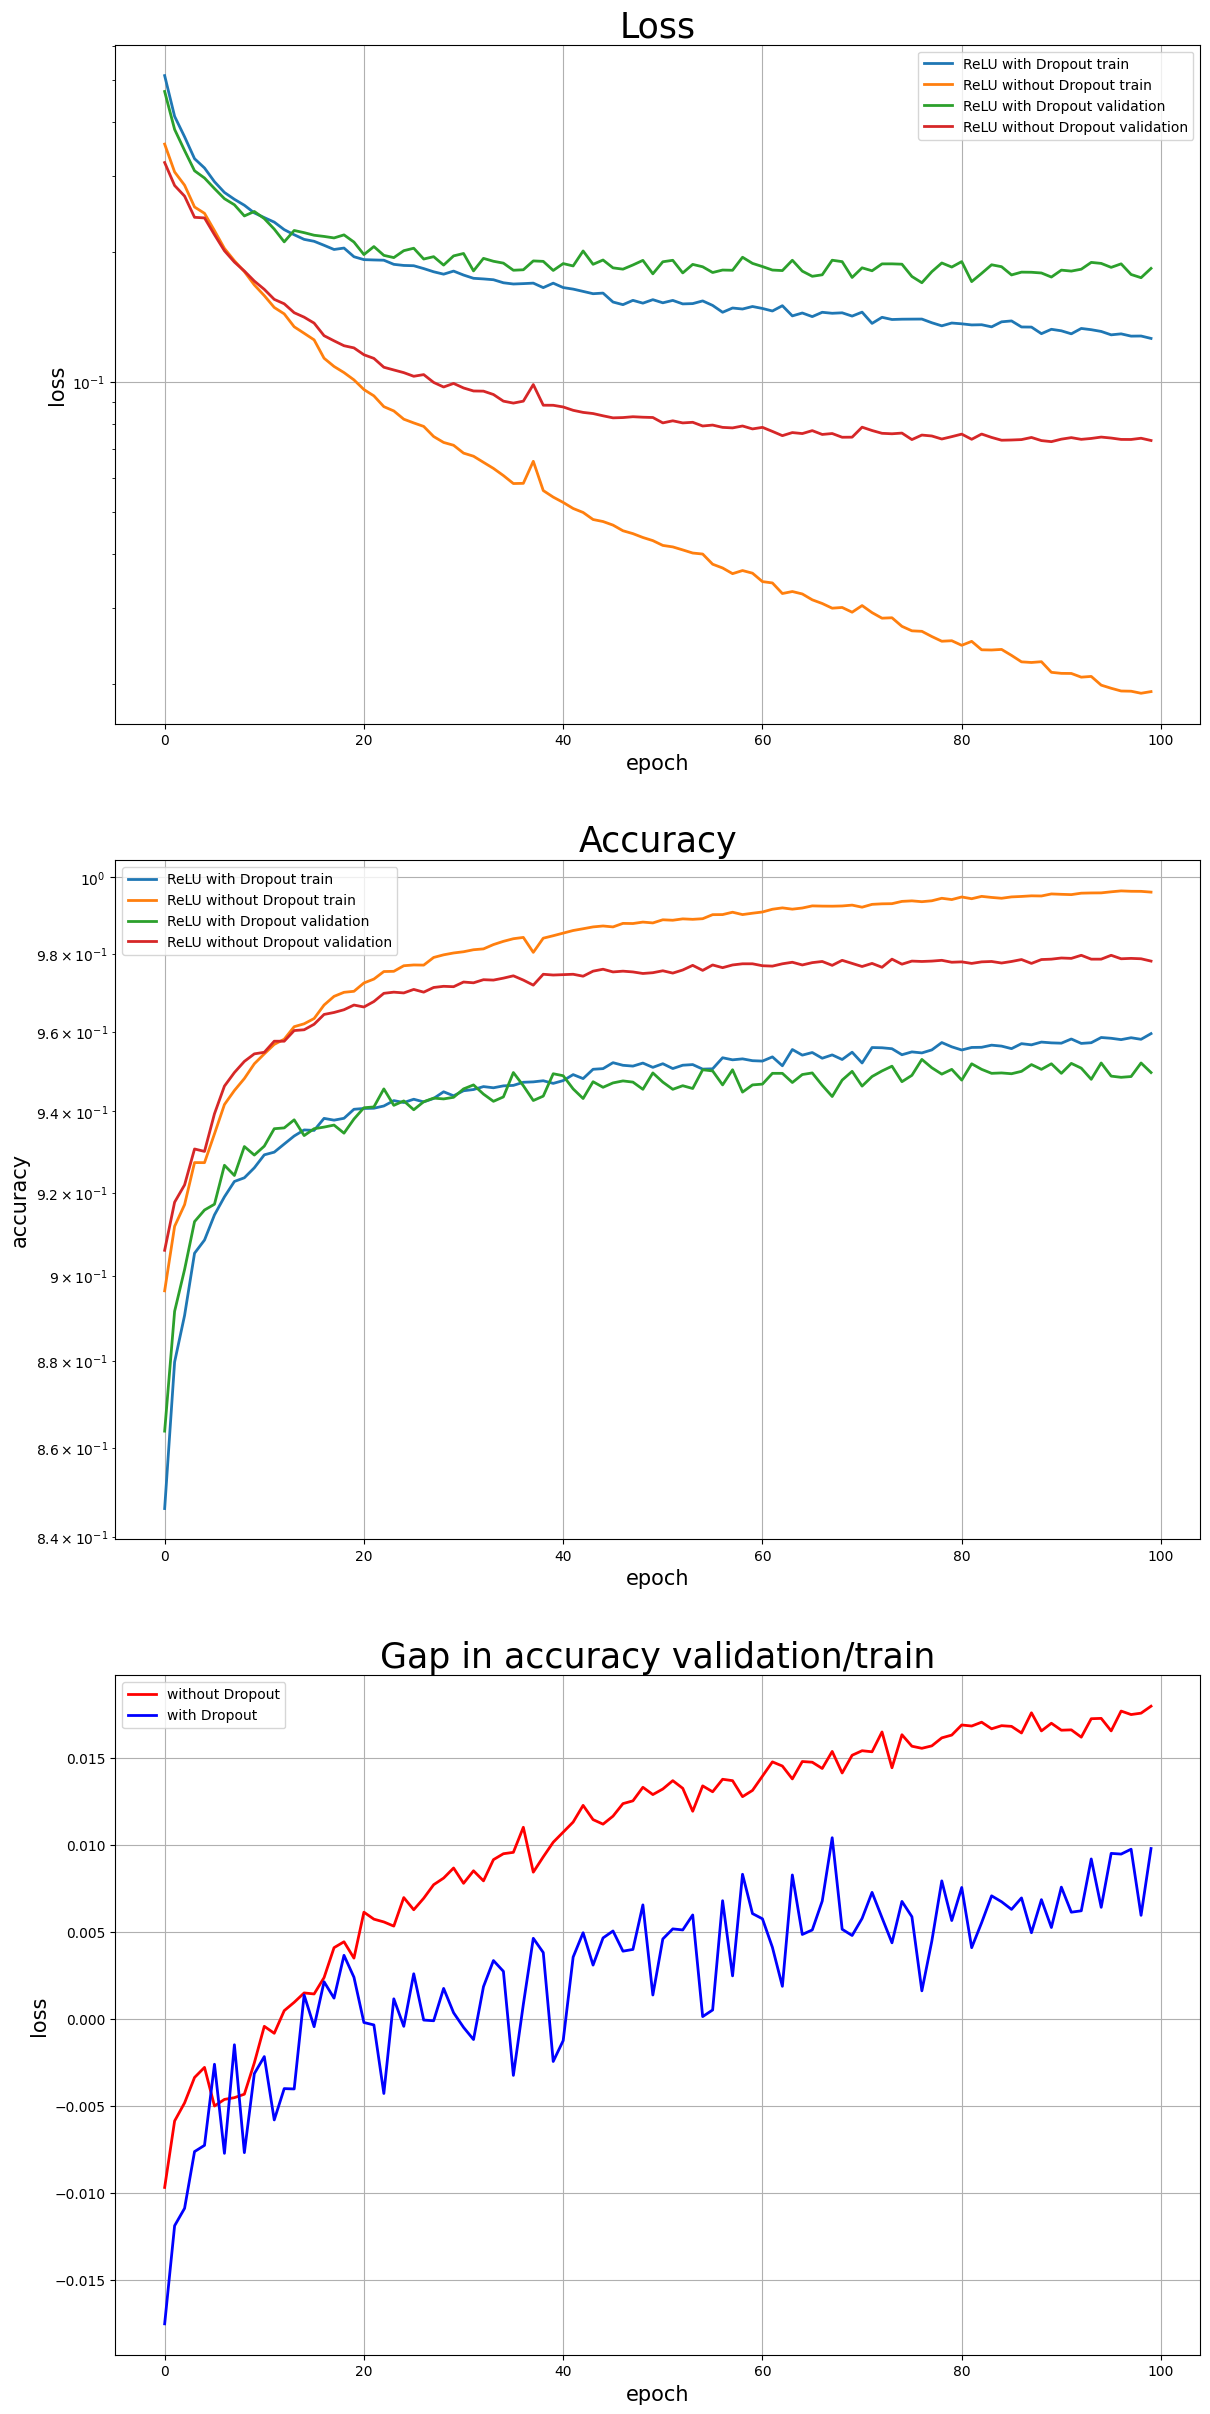

In [14]:
# Your code goes here. ################################################
net_w = Sequential()
net_w.add(Linear(28*28, 600))
net_w.add(Dropout(0.9))
net_w.add(ELU())
net_w.add(Linear(600,10))
net_w.add(LogSoftMax())
criterion_w = ClassNLLCriterion()

net_wo = Sequential()
net_wo.add(Linear(28*28, 600))
net_wo.add(ELU())
net_wo.add(Linear(600,10))
net_wo.add(LogSoftMax())
criterion_wo = ClassNLLCriterion()


n_epoch = 100
batch_size = 1000
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

val_acc_w = []
val_loss_w = []
train_acc_w = []
train_loss_w = []


val_acc_wo = []
val_loss_wo = []
train_acc_wo = []
train_loss_wo = []


for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        
        net_w.zeroGradParameters()
        net_wo.zeroGradParameters()

        
        predictions_w = net_w.forward(x_batch)
        loss_w = criterion_w.forward(predictions_w, y_batch)
        dp_w = criterion_w.backward(predictions_w, y_batch)
        net_w.backward(x_batch, dp_w)
        sgd_momentum(net_w.getParameters(), 
                     net_w.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        
        predictions_wo = net_wo.forward(x_batch)
        loss_wo = criterion_wo.forward(predictions_wo, y_batch)
        dp_wo = criterion_wo.backward(predictions_wo, y_batch)
        net_wo.backward(x_batch, dp_wo)
        sgd_momentum(net_wo.getParameters(), 
                     net_wo.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        
        

    
    
    pred_train_w = net_w.forward(X_train)
    train_loss_w.append(criterion_w.forward(pred_train_w, one_hot_y_train))
    train_acc_w.append(accuracy(pred_train_w,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_w = net_w.forward(X_val)
    val_loss_w.append(criterion_w.forward(pred_val_w, one_hot_y_val))
    val_acc_w.append(accuracy(pred_val_w,np.argmax(one_hot_y_val,axis = -1)))

    
    
    pred_train_wo = net_wo.forward(X_train)
    train_loss_wo.append(criterion_wo.forward(pred_train_wo, one_hot_y_train))
    train_acc_wo.append(accuracy(pred_train_wo,np.argmax(one_hot_y_train,axis = -1)))
    pred_val_wo = net_wo.forward(X_val)
    val_loss_wo.append(criterion_wo.forward(pred_val_wo, one_hot_y_val))
    val_acc_wo.append(accuracy(pred_val_wo,np.argmax(one_hot_y_val,axis = -1)))
      

    # Visualize
    display.clear_output(wait=True)
    print('n_epoch = {} out of {}'.format(i+1,n_epoch)) 
    plt.figure(figsize=(14, 30))

    plt.subplot(3,1,1)
    plt.title("Loss", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.semilogy(train_loss_w, lw = 2, label = 'ReLU with Dropout train')
    plt.semilogy(train_loss_wo, lw = 2, label = 'ReLU without Dropout train')
    plt.semilogy(val_loss_w, lw = 2, label = 'ReLU with Dropout validation')
    plt.semilogy(val_loss_wo, lw = 2, label = 'ReLU without Dropout validation')
    plt.grid(True)
    plt.legend()


    plt.subplot(3,1,2)
    plt.title("Accuracy", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("accuracy", fontsize = 15)
    plt.semilogy(train_acc_w, lw = 2, label = 'ReLU with Dropout train')
    plt.semilogy(train_acc_wo, lw = 2, label = 'ReLU without Dropout train')
    plt.semilogy(val_acc_w, lw = 2, label = 'ReLU with Dropout validation')
    plt.semilogy(val_acc_wo, lw = 2, label = 'ReLU without Dropout validation')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(3,1,3)
    plt.title("Gap in accuracy validation/train", fontsize = 25)
    plt.xlabel("epoch", fontsize = 15)
    plt.ylabel("loss", fontsize = 15)
    plt.plot(np.array(train_acc_wo) - np.array(val_acc_wo), lw = 2,  color = 'r', label = 'without Dropout')
    plt.plot(np.array(train_acc_w) - np.array(val_acc_w), lw = 2, color = 'b', label = 'with Dropout')
    plt.grid(True)
    plt.legend()

    plt.show()

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Epoch 1/10
Train Loss: 0.0010, Train Accuracy: 0.7024
Val Loss: 0.0004, Val Accuracy: 0.8865
Epoch 2/10
Train Loss: 0.0004, Train Accuracy: 0.8673
Val Loss: 0.0004, Val Accuracy: 0.9057
Epoch 3/10
Train Loss: 0.0004, Train Accuracy: 0.8880
Val Loss: 0.0004, Val Accuracy: 0.9062
Epoch 4/10
Train Loss: 0.0003, Train Accuracy: 0.8999
Val Loss: 0.0004, Val Accuracy: 0.8995
Epoch 5/10
Train Loss: 0.0003, Train Accuracy: 0.9073
Val Loss: 0.0004, Val Accuracy: 0.9040
Epoch 6/10
Train Loss: 0.0003, Train Accuracy: 0.9134
Val Loss: 0.0005, Val Accuracy: 0.8961
Epoch 7/10
Train Loss: 0.0003, Train Accuracy: 0.9191
Val Loss: 0.0005, Val Accuracy: 0.8935
Epoch 8/10
Train Loss: 0.0003, Train Accuracy: 0.9197
Val Loss: 0.0005, Val Accuracy: 0.8856
Epoch 9/10
Train Loss: 0.0003, Train Accuracy: 0.9208
Val Loss: 0.0006, Val Accuracy: 0.8844
Epoch 10/10
Train Loss: 0.0003, Train Accuracy: 0.9232
Val Loss: 0.0006, Val Accuracy: 0.8801
Epoch 1/10
Train Loss: 0.0007, Train Accuracy: 0.8126
Val Loss: 0.000

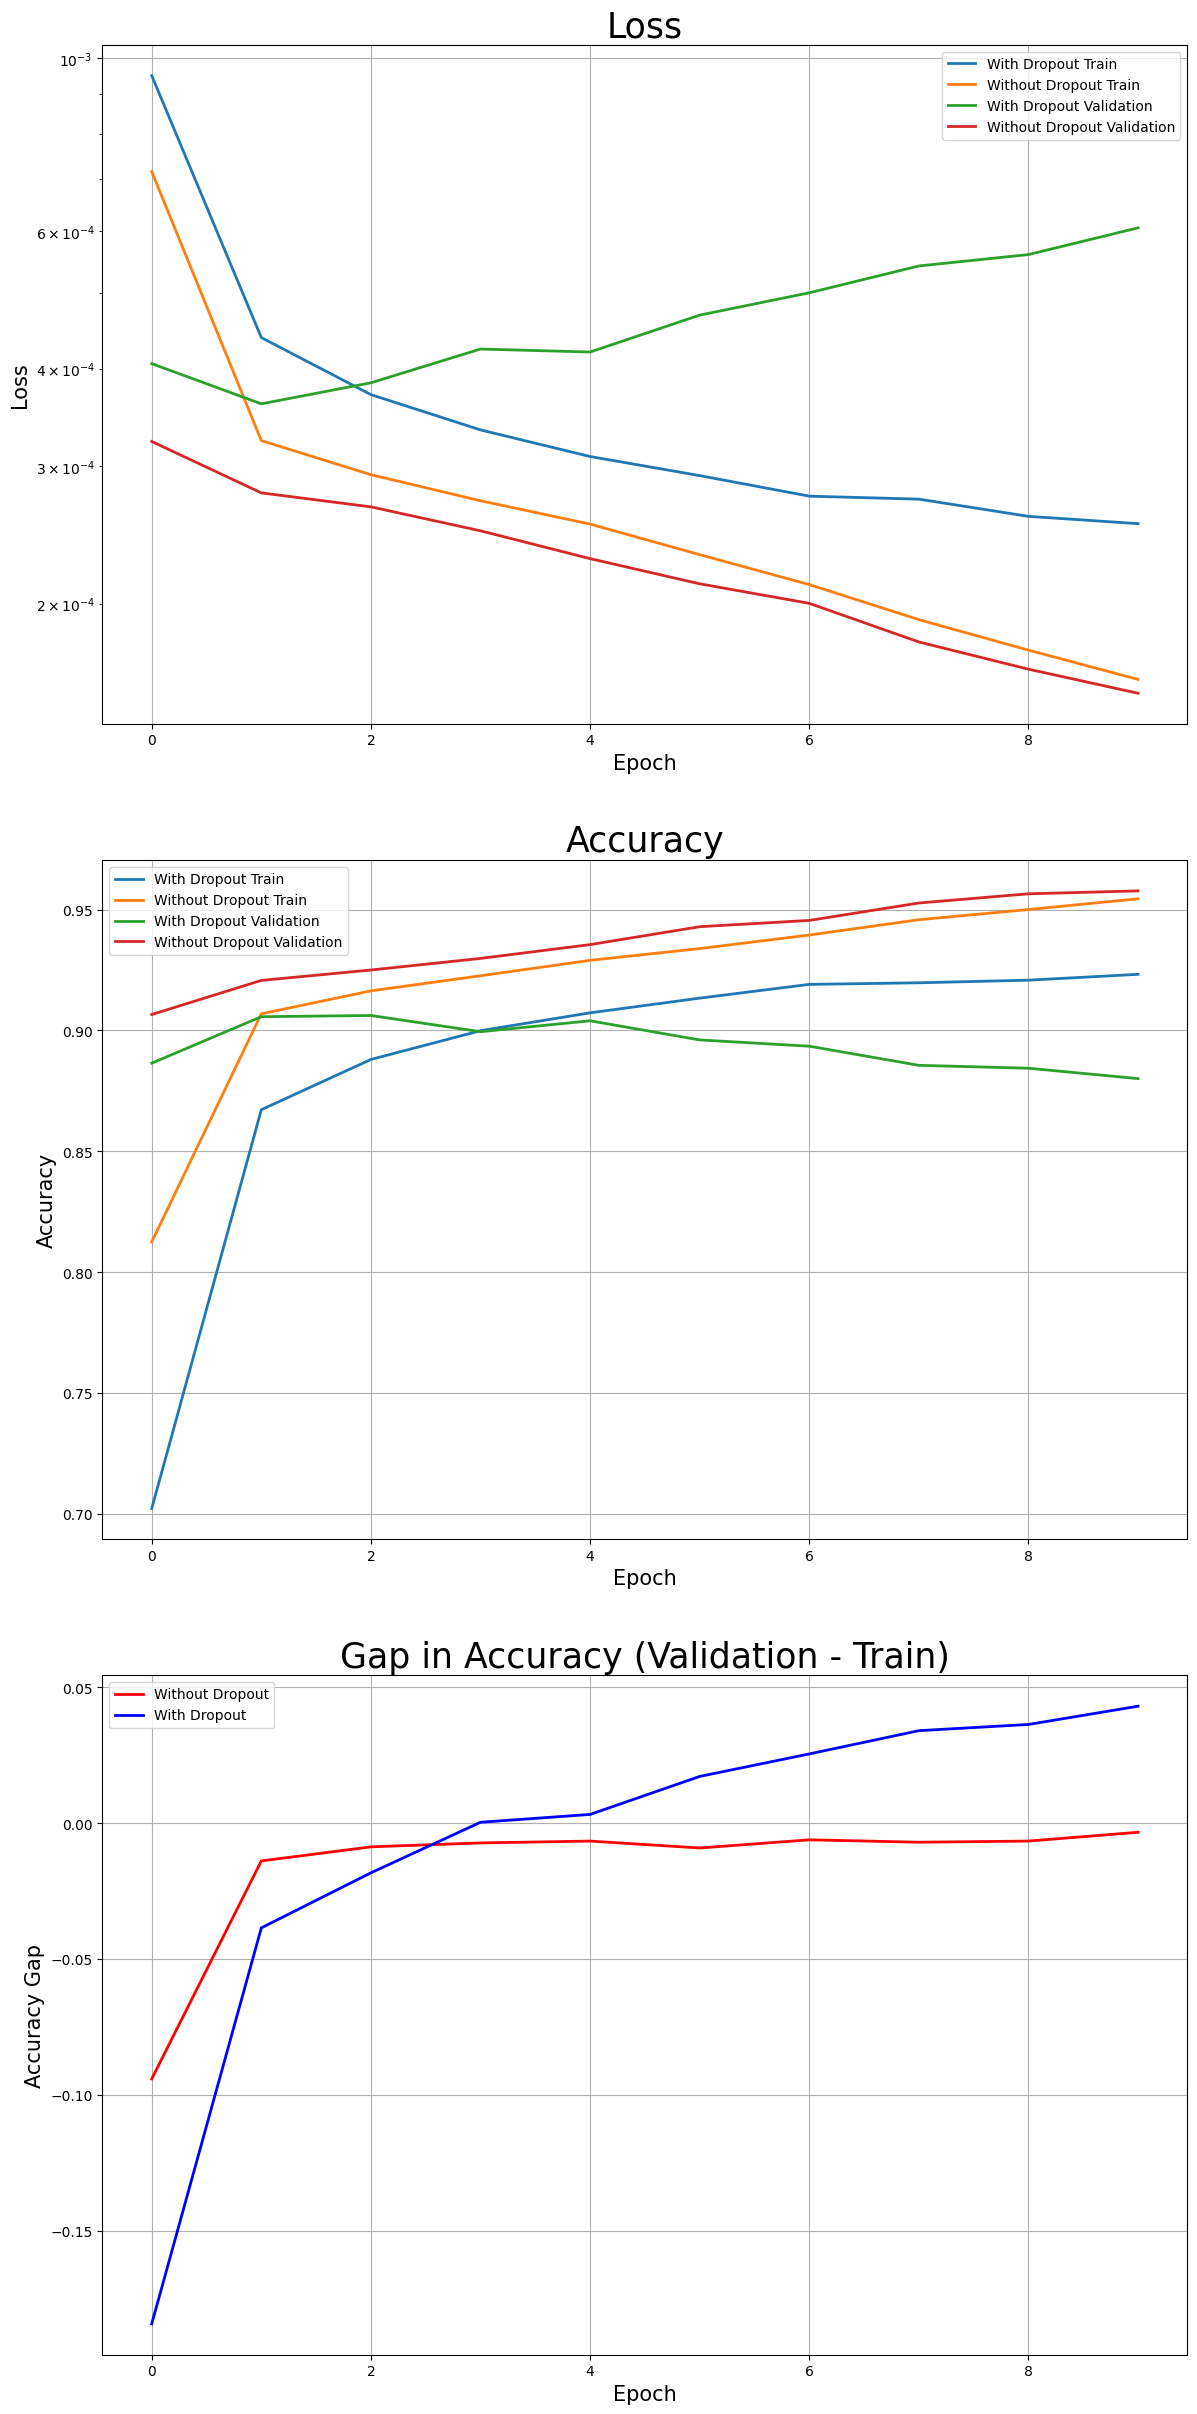

In [15]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Определение модели
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 600)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.9)
        self.fc2 = nn.Linear(600, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

class NetWithoutDropout(nn.Module):
    def __init__(self):
        super(NetWithoutDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 600)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(600, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

# Функция обучения
def train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y_val).sum().item()

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        # Logging
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Датасеты и DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

# Инициализация моделей, оптимизаторов и функции потерь
net_with_dropout = NetWithDropout()
net_without_dropout = NetWithoutDropout()

optimizer_with_dropout = optim.SGD(net_with_dropout.parameters(), lr=0.1, momentum=0.9)
optimizer_without_dropout = optim.SGD(net_without_dropout.parameters(), lr=0.1, momentum=0.9)

criterion = nn.NLLLoss()

# Обучение моделей
train_loss_w, train_acc_w, val_loss_w, val_acc_w = train_model(
    net_with_dropout, optimizer_with_dropout, criterion, train_loader, val_loader, n_epochs=10
)

train_loss_wo, train_acc_wo, val_loss_wo, val_acc_wo = train_model(
    net_without_dropout, optimizer_without_dropout, criterion, train_loader, val_loader, n_epochs=10
)

# Визуализация
plt.figure(figsize=(14, 30))

# Loss
plt.subplot(3, 1, 1)
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.semilogy(train_loss_w, lw=2, label="With Dropout Train")
plt.semilogy(train_loss_wo, lw=2, label="Without Dropout Train")
plt.semilogy(val_loss_w, lw=2, label="With Dropout Validation")
plt.semilogy(val_loss_wo, lw=2, label="Without Dropout Validation")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(3, 1, 2)
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.plot(train_acc_w, lw=2, label="With Dropout Train")
plt.plot(train_acc_wo, lw=2, label="Without Dropout Train")
plt.plot(val_acc_w, lw=2, label="With Dropout Validation")
plt.plot(val_acc_wo, lw=2, label="Without Dropout Validation")
plt.grid(True)
plt.legend()

# Gap in accuracy
plt.subplot(3, 1, 3)
plt.title("Gap in Accuracy (Validation - Train)", fontsize=25)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy Gap", fontsize=15)
plt.plot(np.array(train_acc_wo) - np.array(val_acc_wo), lw=2, color="r", label="Without Dropout")
plt.plot(np.array(train_acc_w) - np.array(val_acc_w), lw=2, color="b", label="With Dropout")
plt.grid(True)
plt.legend()

plt.show()
